#SVM - Classifying Spam
## Brady Young

---


## Modules

In [0]:
from sklearn import preprocessing #Create standardized scaler to apply to train and test data
from sklearn import svm           #The core SVM module
from sklearn import exceptions    #Exceptions specific to sklearn
from sklearn import metrics       #Used to grab SVM's performance on test data
import numpy as np                #Used for array operations
import math                       #Used for floor
import requests                   #Used to download dataset
import sys                        #Used to format printing
import os                         #Used to manage filesystem
import matplotlib.pyplot as plt   #Used to plot data        
import warnings                   #Manage warning display
import random                     #Grab N random samples from a population

##Data Acquisition, Preprocessing, and Plotting

In [0]:
#Creates directory for writing data files
if(os.path.isdir('data') == False):
  os.makedirs('data')
  
#Writes dataset and remote location to local files
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'
r = requests.get(link)
with open('data/spambase.data', 'wb') as file:
  file.write(r.content)

### Dataset

In [0]:
#A wrapper to process the dataset after reading
class Dataset:
  def __init__(self, file):
    self.trainset = []
    self.testset = []
    self.goalset = []
    self.testgoalset = []
    
    self.load(file)
    self.process()
    self.scale()

  #Copies the data into memory
  def load(self, file):
    with open('data/spambase.data', mode='r') as file:
      self.fileIn = file.read()
    
  def process(self):
    halfSetLen = math.floor(len(self.fileIn)/2)
    featureSets = self.fileIn.split("\n")
    
    for i in range(len(featureSets)):
      featureSets[i] = str(featureSets[i])
      self.trainset.append(featureSets[i].split(","))
      self.goalset.append(self.trainset[-1].pop(-1))
      
      if((i%2) == 0):
        self.testset.append(featureSets[i+1].split(","))
        self.testgoalset.append(self.testset[-1].pop(-1))
    
    self.trainset.pop(-1)
    self.testset.pop(-1)
    self.goalset.pop(-1)
    self.testgoalset.pop(-1)
    self.trainset = np.array(self.trainset, 'float64')
    self.testset = np.array(self.testset, 'float64')
    self.goalset = np.array(self.goalset, 'float64')
    self.testgoalset = np.array(self.testgoalset, 'float64')
    
  def scale(self):
    scale = preprocessing.StandardScaler().fit(self.trainset)
    scale.transform(self.trainset)
    scale.transform(self.testset)
    self.remove(scale)
    
  def remove(self, scale):
    for d in self.trainset:
      for i in range(len(d)):
        if(scale.var_[i] == 0):
          d[i] = 0
    for d in self.testset:
      for i in range(len(d)):
        if(scale.var_[i] == 0):
          d[i] = 0
    
# Instantiates the dataset
dataset = Dataset(file)

###Plotting

In [0]:
def plot_roc(svm):
  plt.figure()
  lw = 1
  plt.plot(svm.fpr, svm.tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % svm.auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

def plot_acc(accuracies):
  plt.figure()
  lw = 2
  m = range(0, len(accuracies))
  plt.plot(m, accuracies, color='darkorange',
         lw=lw, label='Accuracy')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([2, len(accuracies)])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Number of Features')
  plt.ylabel('Accuracy')
  plt.show()
  print("Max Accuracy: ", max(accuracies), "Avg: ", sum(accuracies)/len(accuracies) )

## SVM

In [0]:
class SVM:
  def __init__(self, dataset):
    self.data = dataset
    self.linear = svm.LinearSVC()
    self.trainset = []
    self.testset = []
    
  def run(self, features = []):
    if (len(features) == 0):
        features = list(range(len(self.data.testset[0])))
        
    for d in self.data.trainset:
      vector = []
      for i in range(len(features)):
        vector.append(d[features[i]])
      self.trainset.append(vector)
    
    for d in self.data.testset:
      vector = []
      for i in range(len(features)):
        vector.append(d[features[i]])
      self.testset.append(vector)
      
    self.train()
    self.test()
    
  def train(self):
    #Ignores specific warning arising from convergence
    warnings.filterwarnings("ignore", category=exceptions.ConvergenceWarning)
    self.linear.fit(self.trainset, self.data.goalset)
  
  def test(self):
    predict = self.linear.predict(self.testset)
    decision = self.linear.decision_function(self.testset)

    #Ignores specific warning arising from no predictions
    warnings.filterwarnings("ignore", category=exceptions.UndefinedMetricWarning)
    
    self.accuracy = metrics.accuracy_score(self.data.testgoalset, predict)
    self.precision = metrics.precision_score(self.data.testgoalset, predict)
    self.recall = metrics.recall_score(self.data.testgoalset, predict)
    
    self.fpr, self.tpr, _ = metrics.roc_curve(self.data.testgoalset, decision)
    self.auc = metrics.roc_auc_score(self.data.testgoalset, predict)

  def print_results(self):
    print("Accuracy: ", self.accuracy, \
      "Precision: ", self.precision, \
      "Recall: ", self.recall)

##Experiment One

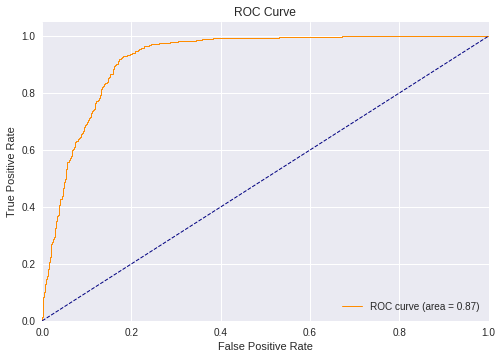

Accuracy:  0.8626086956521739 Precision:  0.7746741154562383 Recall:  0.9183222958057395


In [0]:
linearSVM = SVM(dataset)
linearSVM.run()
plot_roc(linearSVM)
linearSVM.print_results()

For this project I used the scikit-learn package to create the SVM and preprocess the input data.

## Experiment Two

### Weight Vector

In [0]:
weights = linearSVM.linear.coef_
print(weights)

[[-0.09230522 -0.01224889  0.01398819  0.30366414  0.10574054  0.06017254
   0.77169614  0.19805535 -0.02284791 -0.01423384  0.0863804  -0.01722679
  -0.05993933 -0.02870938 -0.00164192  0.2952751   0.36073408  0.12243668
   0.04802245  0.42156222  0.03345846 -0.06413105  0.31535299  0.0674276
  -0.36609239 -0.00952286 -0.79575481  0.08054677 -0.45800797 -0.88725486
  -0.28486941 -0.07139645 -0.07108003 -0.04214688 -0.5383509   0.17269864
  -0.03139007 -0.15970145 -0.29195766 -0.05438864 -0.28206245 -0.60951013
  -0.30009775 -0.51316737 -0.27184433 -0.40701683 -0.45667623 -0.52224524
  -0.13715998 -0.16600298 -0.29172407  0.11417718  1.46968356  0.34640628
   0.05562224  0.00736554 -0.01342965]]


### Feature Selection

In [0]:
accuracies = []
topFeatures = np.argsort(weights)[0][::-1]
for i in range(2, len(linearSVM.testset[0])):
  featuresToUse = topFeatures[:i]
  mSVM = SVM(dataset)
  mSVM.run(featuresToUse)
  accuracies.append(mSVM.accuracy)

### Plot

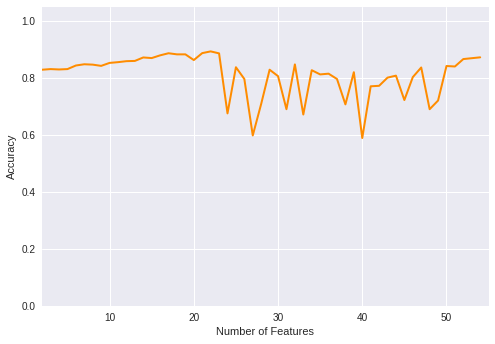

Max Accuracy:  0.8934782608695652 Avg:  0.8115573122529645


In [0]:
plot_acc(accuracies)

### Top Features

In [0]:
topFiveFeatures = np.argsort(weights)[0][::-1][:5]
print(topFiveFeatures)

[52  6 19 16 53]


**Feature 52:** Frequency of character "!" <br>
**Feature 6:** Frequency of word "over" <br>
**Feature 19:** Frequency of word "you" <br>
**Feature 16:** Frequency of word "free" <br>
**Feature 53:** Frequency of character "$" <br>

The highest weighted features are not surprising given the usual intent of spam: to obtain money from the receipient. In spam e-mails, it is common to observe exclamation points in quite long sequences in order to communicate emergency or excitement, so its presence as the most weight feature is expectable.

Selecting a subset of features containing the highest weighted features resulted in lower-dimensional support vectors. As the number of features grew, the dimensionality of the vectors increased, leading to more nuance in its classification ability. Surprisingly, it only takes the presence of one feature to correctly discriminate just over 80\% of the test cases. Additionally surprising,  certain features seem to impair the accuracy of the SVM. Perhaps the features that decrease the accuracy are not linearly separable and require something more complex than a linear kernel. As an additional experiment, I created a SVM that uses only the weights that resulted in an increase in accuracy.



### Extra

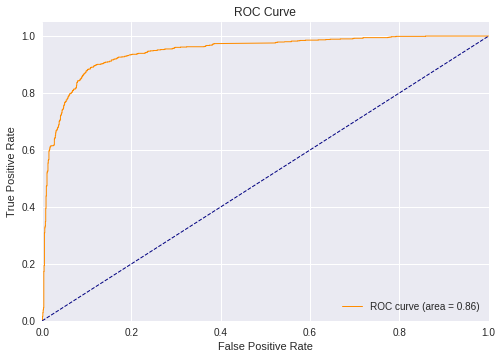

Accuracy:  0.8765217391304347 Precision:  0.9081364829396326 Recall:  0.7637969094922737


In [0]:
onlyBest = []
onlyBest.append(topFeatures[0])
onlyBest.append(topFeatures[1])
for i in range(2, len(accuracies)):
  if(accuracies[i] > accuracies[i-1]):
    onlyBest.append(topFeatures[i])
     
bestSVM = SVM(dataset)
bestSVM.run(onlyBest)
plot_roc(bestSVM)
bestSVM.print_results()

## Experiment Three

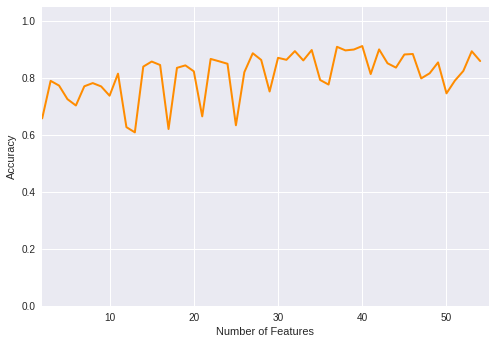

Max Accuracy:  0.9121739130434783 Avg:  0.8060395256916996


In [0]:
weights = linearSVM.linear.coef_
accuracies = []
numFeatures = len(linearSVM.testset[0])
for i in range(2, numFeatures):
  featuresToUse = random.sample(range(numFeatures), i)
  mSVM = SVM(dataset)
  mSVM.run(featuresToUse)
  accuracies.append(mSVM.accuracy)
plot_acc(accuracies)

Randomly choosing which features to train the SVM with seems to produce less accurate models on average, yet do result in producing a model that has better accuracy than the previous experiment. It seems particular sets of features produce higher accuracies than the previous network. Even compared to the extra network that only kept features that increased the accuracy, a randomized feature set produced more accurate results. Certain permutations of features may contain more or less linearly separable features, leading to a wide variance in their accuracies. From here, sampling additional features using an initial feature set of highest accuracy result of this experiment might produce better models.